### This notebook shows countsplitting applied on real pmbc3k data. 
Conclusion is that <br>
(1)countsplitting show very minor effect on "positive control, where "positive control" means the clusters <br>in train are real biological clusters and are decently well reproduced, if not perfectly, in test half of the data <br>
(2)The inflation in DE between celltype QQ plot is now dominated by treating each cell as independent obs <br>
So dont expect the QQ plot of DE between celltype in test data miraculously got flattened 

Note that this does not directly contradict what is shown in the paper. Majority of the paper demostrate the effect of "negative control" <br>
### Show this in 3 section
DE on distinct B cells vs rest <br>
DE on subtype CD4 cells vs rest  (adapted from their tutorial)<br>
DE on subtype CD4 cells vs another subtype of CD4 <br>

In [1]:
library(Seurat)
library(countsplit)
library(ggplot2)
library(patchwork)
library(mclust)
source("utils.r")

Attaching SeuratObject

Package 'mclust' version 5.4.8
Type 'citation("mclust")' for citing this R package in publications.

hash-2.2.6.2 provided by Decision Patterns



Attaching package: ‘rlang’


The following object is masked from ‘package:hash’:

    hash


Registering fonts with R

NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow



In [2]:
set.seed(1)
data(pbmc.counts, package="countsplit")
rownames(pbmc.counts) <- sapply(rownames(pbmc.counts), function(u) stringr::str_replace_all(u, "_","-"))

split  <- countsplit(pbmc.counts, epsilon=0.5)
Xtrain <- split$train
Xtest  <- split$test

# CountSplit Train: pmbc.train

In [3]:
pbmc.train <- CreateSeuratObject(counts = Xtrain, min.cells = 3, min.features = 200)
pbmc.train[["percent.mt"]] <- PercentageFeatureSet(pbmc.train, pattern = "^MT-")
pbmc.train <- subset(pbmc.train, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
pbmc.train <- NormalizeData(pbmc.train)
pbmc.train <- FindVariableFeatures(pbmc.train, selection.method = "vst", nfeatures = 2000)
pbmc.train <- ScaleData(pbmc.train,features = rownames(pbmc.train))
pbmc.train <- RunPCA(pbmc.train, features = VariableFeatures(object = pbmc.train))
pbmc.train <- FindNeighbors(pbmc.train, dims = 1:10)
pbmc.train <- FindClusters(pbmc.train, resolution= 0.5)
pbmc.train <- RunUMAP(pbmc.train, dims = 1:10)

Warning message:
“The following arguments are not used: row.names”
Centering and scaling data matrix

PC_ 1 
Positive:  MALAT1, LTB, IL32, IL7R, B2M, CD2, CTSW, ACAP1, CCL5, CD247 
	   GZMM, STK17A, GZMA, RPS2, CST7, SELL, AQP3, GZMK, RARRES3, NKG7 
	   HOPX, GIMAP5, MAL, ITM2A, CD79A, KLRG1, PRF1, BEX2, TRAF3IP3, ETS1 
Negative:  CST3, TYROBP, AIF1, LST1, LYZ, S100A9, FCER1G, FCN1, LGALS1, TYMP 
	   FTL, FTH1, CFD, CTSS, S100A8, IFITM3, CD68, PSAP, SAT1, COTL1 
	   LGALS2, SERPINA1, S100A11, NPC2, CFP, SPI1, S100A6, IFI30, GRN, LGALS3 
PC_ 2 
Positive:  NKG7, GZMB, PRF1, CST7, GZMA, GNLY, FGFBP2, B2M, CTSW, CCL5 
	   GZMH, CCL4, FCGR3A, SPON2, CD247, GZMM, CLIC3, XCL2, HOPX, SRGN 
	   APMAP, ACTB, PFN1, CTSC, IL32, RARRES3, IGFBP7, S100A4, TTC38, ID2 
Negative:  CD79A, HLA-DRA, HLA-DQB1, HLA-DQA1, MS4A1, TCL1A, CD79B, HLA-DPB1, LINC00926, HLA-DRB1 
	   CD74, CD37, RPS2, HLA-DPA1, HLA-DQA2, LTB, HLA-DRB5, HLA-DMA, HLA-DMB, HVCN1 
	   IGLL5, FCRLA, IRF8, BLNK, KIAA0125, C16orf74, ARHGAP

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2615
Number of edges: 95044

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8613
Number of communities: 7
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:52:29 UMAP embedding parameters a = 0.9922 b = 1.112

13:52:29 Read 2615 rows and found 10 numeric columns

13:52:29 Using Annoy for neighbor search, n_neighbors = 30

13:52:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:52:29 Writing NN index file to temp file /tmp/RtmppQHRj6/file11d7552fee1d

13:52:29 Searching Annoy index using 1 thread, search_k = 3000

13:52:30 Annoy recall = 100%

13:52:30 Commencing smooth kNN distance calibration using 1 thread

13:52:31 Initializing fro

# CountSplit Test: pmbc.test

In [4]:
pbmc.test <- CreateSeuratObject(counts=Xtest[rownames(pbmc.train),colnames(pbmc.train)])
print("adding train label as train.anno")
pbmc.test <- AddMetaData(pbmc.test, pbmc.train@meta.data[,"seurat_clusters", drop = F], col.name = "train.anno")
pbmc.test <- NormalizeData(pbmc.test)
pbmc.test <- FindVariableFeatures(pbmc.test, selection.method = "vst", nfeatures = 2000)
pbmc.test <- ScaleData(pbmc.test, features = rownames(pbmc.test))
pbmc.test <- RunPCA(pbmc.test, features = VariableFeatures(object = pbmc.test))
pbmc.test <- FindNeighbors(pbmc.test, dims = 1:10)
pbmc.test <- FindClusters(pbmc.test, resolution= 0.5)
pbmc.test <- RunUMAP(pbmc.test, dims = 1:10)

[1] "adding train label as train.anno"


Centering and scaling data matrix

PC_ 1 
Positive:  CST3, TYROBP, AIF1, LST1, LYZ, FCN1, S100A9, FCER1G, LGALS1, FTL 
	   TYMP, FTH1, CFD, S100A8, CTSS, COTL1, LGALS2, SAT1, IFITM3, PSAP 
	   SPI1, S100A11, SERPINA1, NPC2, CFP, GSTP1, S100A6, IFI30, LGALS3, GPX1 
Negative:  MALAT1, LTB, IL32, IL7R, B2M, CD2, CCL5, CTSW, STK17A, CD247 
	   CD27, NOSIP, RPS2, ACAP1, GIMAP5, AQP3, TRAF3IP3, CST7, SELL, GZMA 
	   GZMK, MAL, NKG7, MYC, LDLRAP1, TCF7, PRF1, HOPX, CD79A, ETS1 
PC_ 2 
Positive:  CD79A, HLA-DRA, TCL1A, MS4A1, CD79B, HLA-DQA1, HLA-DQB1, LINC00926, VPREB3, CD74 
	   HLA-DRB1, HLA-DPB1, HLA-DPA1, HLA-DMA, HLA-DRB5, RPS2, LTB, FCRLA, HLA-DMB, HVCN1 
	   IGLL5, P2RX5, SWAP70, S100A8, IRF8, BLNK, S100A9, LGALS2, SMIM14, IL4R 
Negative:  NKG7, GZMB, PRF1, GZMA, CST7, FGFBP2, GNLY, CTSW, B2M, GZMH 
	   SPON2, CCL5, CCL4, FCGR3A, CLIC3, CD247, HOPX, XCL2, PFN1, TTC38 
	   IGFBP7, AKR1C3, SRGN, IL32, APOBEC3G, ACTB, S100A4, ACTG1, ID2, TPST2 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HL

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2615
Number of edges: 96797

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8588
Number of communities: 8
Elapsed time: 0 seconds


13:52:50 UMAP embedding parameters a = 0.9922 b = 1.112

13:52:50 Read 2615 rows and found 10 numeric columns

13:52:50 Using Annoy for neighbor search, n_neighbors = 30

13:52:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:52:51 Writing NN index file to temp file /tmp/RtmppQHRj6/file11d77fd33386

13:52:51 Searching Annoy index using 1 thread, search_k = 3000

13:52:52 Annoy recall = 100%

13:52:52 Commencing smooth kNN distance calibration using 1 thread

13:52:52 Initializing from normalized Laplacian + noise

13:52:52 Commencing optimization for 500 epochs, with 105442 positive edges

13:53:01 Optimization finished



# Full: pmbc

In [5]:
pbmc <- CreateSeuratObject(counts = pbmc.counts, min.cells = 3, min.features = 200)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
pbmc <- ScaleData(pbmc,features = rownames(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution= 0.5)
pbmc <- RunUMAP(pbmc, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95927

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8728
Number of communities: 9
Elapsed time: 0 seconds


13:53:14 UMAP embedding parameters a = 0.9922 b = 1.112

13:53:14 Read 2638 rows and found 10 numeric columns

13:53:14 Using Annoy for neighbor search, n_neighbors = 30

13:53:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:53:14 Writing NN index file to temp file /tmp/RtmppQHRj6/file11d761680cb

13:53:14 Searching Annoy index using 1 thread, search_k = 3000

13:53:15 Annoy recall = 100%

13:53:15 Commencing smooth kNN distance calibration using 1 thread

13:53:16 Initializing from normalized Laplacian + noise

13:53:16 Commencing optimization for 500 epochs, with 105140 positive edges

13:53:24 Optimization finished



# Compare pmbc vs pmbc.train HVG

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


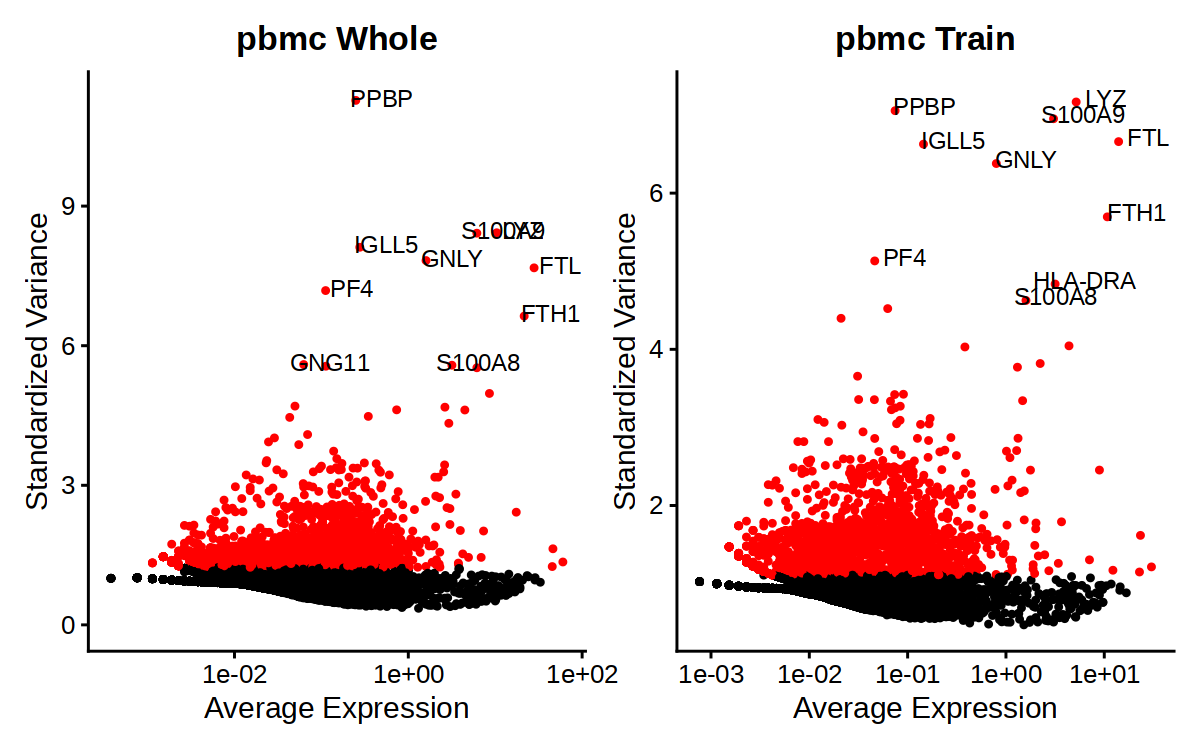

In [6]:
top10 <- head(VariableFeatures(pbmc), 10)
plot1 <- VariableFeaturePlot(pbmc) + ggtitle("pbmc Whole")
plot2 <- LabelPoints(plot = plot1, points = top10)
top10.train <- head(VariableFeatures(pbmc.train), 10)
plot1.train <- VariableFeaturePlot(pbmc.train) + ggtitle("pbmc Train")
plot2.train <- LabelPoints(plot = plot1.train, points = top10.train)

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 150)
plot2 + plot2.train & guides(col="none")

In [7]:
sort(top10)
##  [1] "FTH1"   "FTL"    "GNG11"  "GNLY"   "IGLL5"  "LYZ"    "PF4"    "PPBP"  
##  [9] "S100A8" "S100A9"
sort(top10.train)
##  [1] "FTH1"    "FTL"     "GNLY"    "HLA-DRA" "IGLL5"   "LYZ"     "PF4"    
##  [8] "PPBP"    "S100A8"  "S100A9"

[1] "FTH1"   "FTL"    "GNG11"  "GNLY"   "IGLL5"  "LYZ"    "PF4"    "PPBP"  
 [9] "S100A8" "S100A9"

[1] "FTH1"    "FTL"     "GNLY"    "HLA-DRA" "IGLL5"   "LYZ"     "PF4"    
 [8] "PPBP"    "S100A8"  "S100A9"

# Compare pmbc vs pmbc.train vs pmbv.test clusters

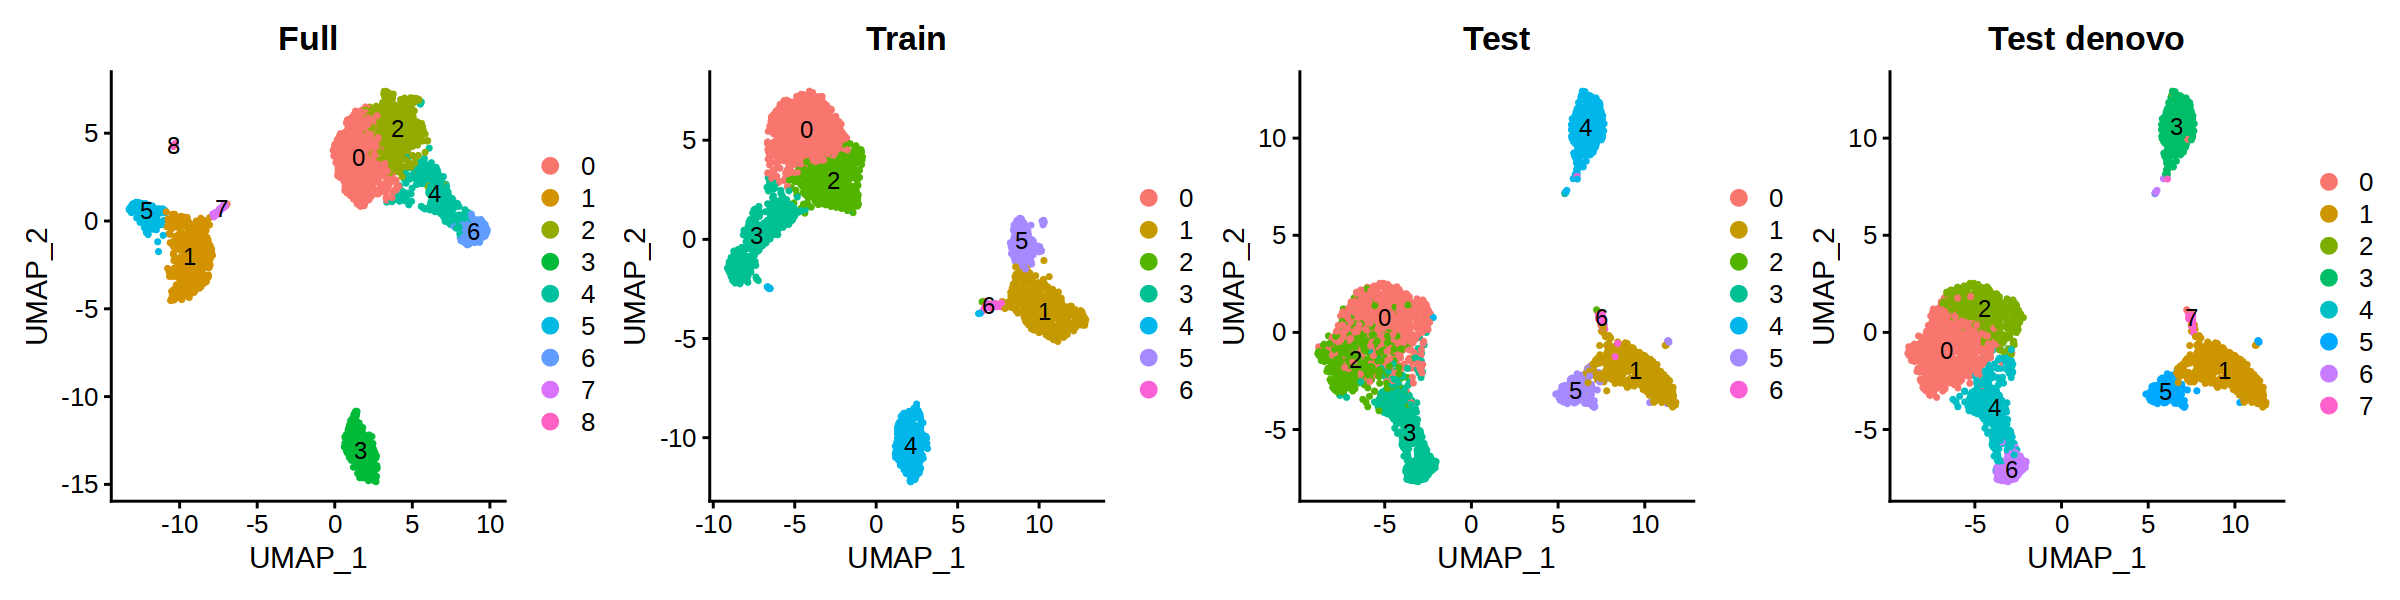

In [8]:
p1 = DimPlot(pbmc,       reduction = "umap", label = T) + ggtitle("Full") +  theme(plot.title = element_text(hjust = 0.5))
p2 = DimPlot(pbmc.train, reduction = "umap", label = T) + ggtitle("Train") +  theme(plot.title = element_text(hjust = 0.5))
p3 = DimPlot(pbmc.test,  reduction = "umap", group.by = "train.anno",      label = T) + ggtitle("Test") +  theme(plot.title = element_text(hjust = 0.5))
p4 = DimPlot(pbmc.test,  reduction = "umap", group.by = "seurat_clusters", label = T) + ggtitle("Test denovo") +  theme(plot.title = element_text(hjust = 0.5))
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
p1 + p2 + p3 + p4 + plot_layout(nrow=1, ncol=4)

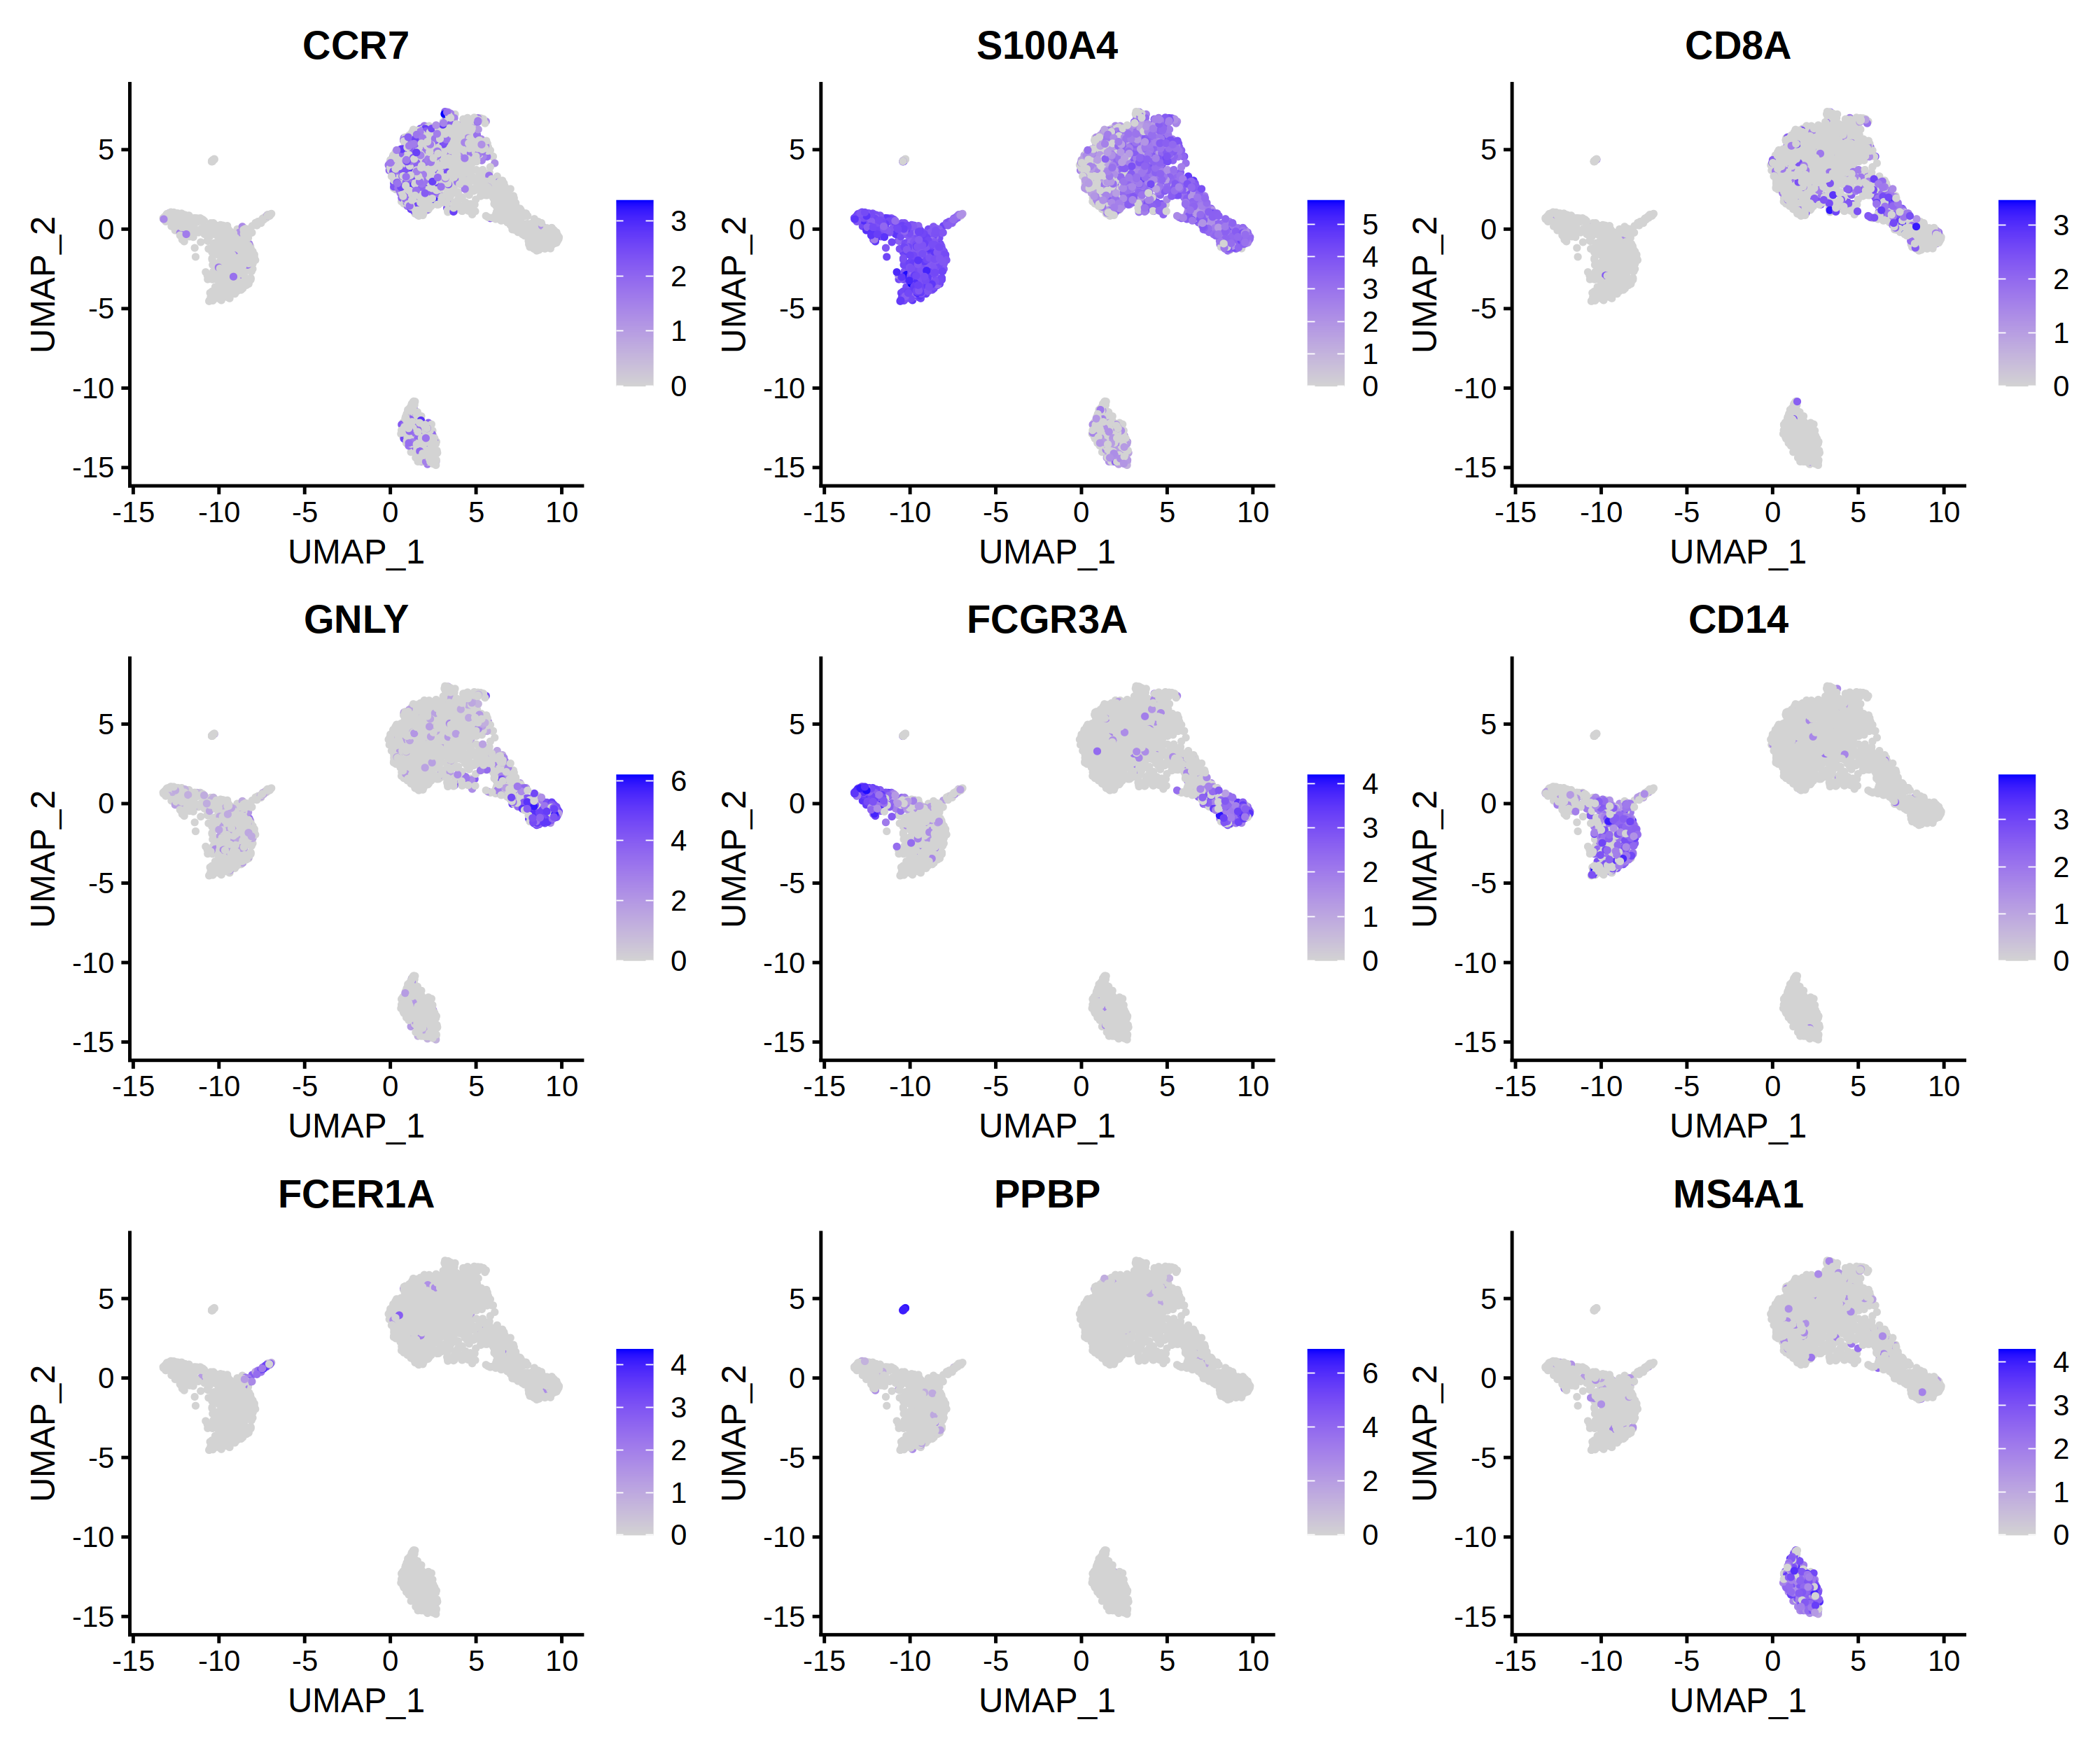

In [9]:
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 250)
FeaturePlot(pbmc, 
            features = c("CCR7",    # Naive CD4+ T
                         "S100A4",  # memory CD4+
                         "CD8A",    # CD8T
                         "GNLY",    # NK 

                         "FCGR3A",  # FCGR3A+ mono
                         "CD14",    # CD14+ mono
                         "FCER1A",  # DC

                         "PPBP",    # Platelet 
                         "MS4A1"  # B
                         ))

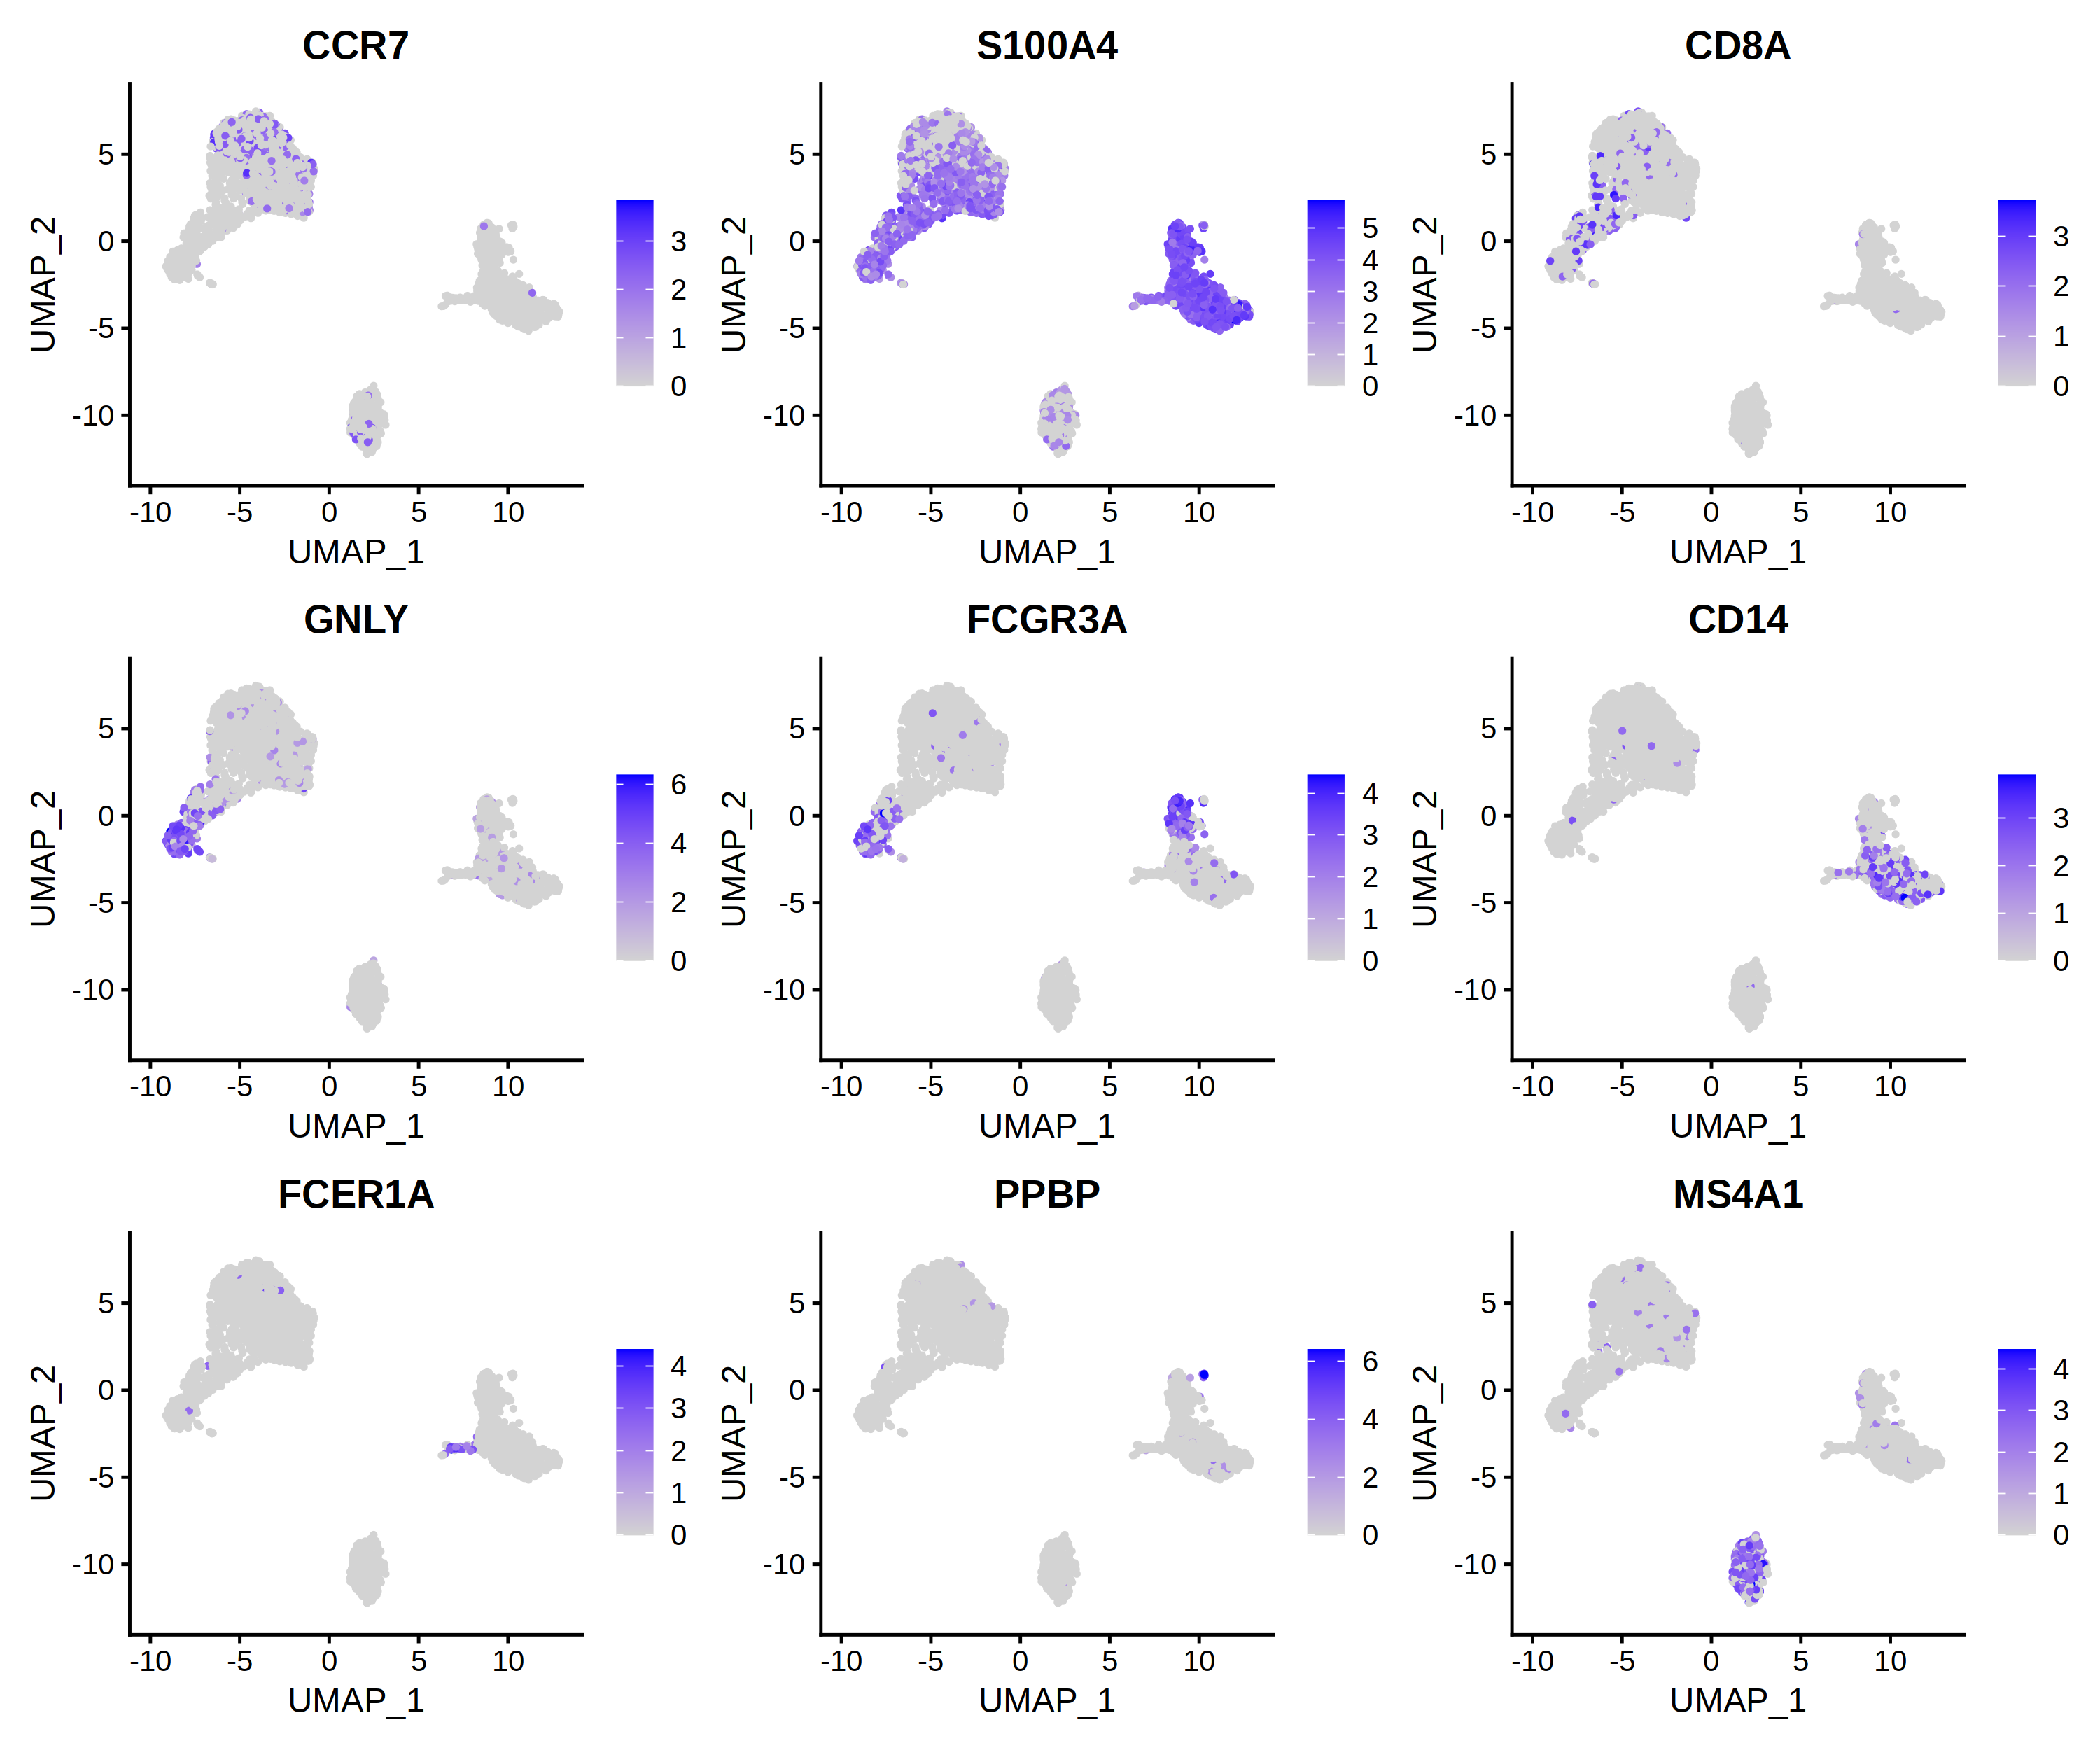

In [10]:
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 250)
FeaturePlot(pbmc.train, 
            features = c("CCR7",    # Naive CD4+ T
                         "S100A4",  # memory CD4+
                         "CD8A",    # CD8T
                         "GNLY",    # NK 

                         "FCGR3A",  # FCGR3A+ mono
                         "CD14",    # CD14+ mono
                         "FCER1A",  # DC

                         "PPBP",    # Platelet 
                         "MS4A1"  # B
                         ))

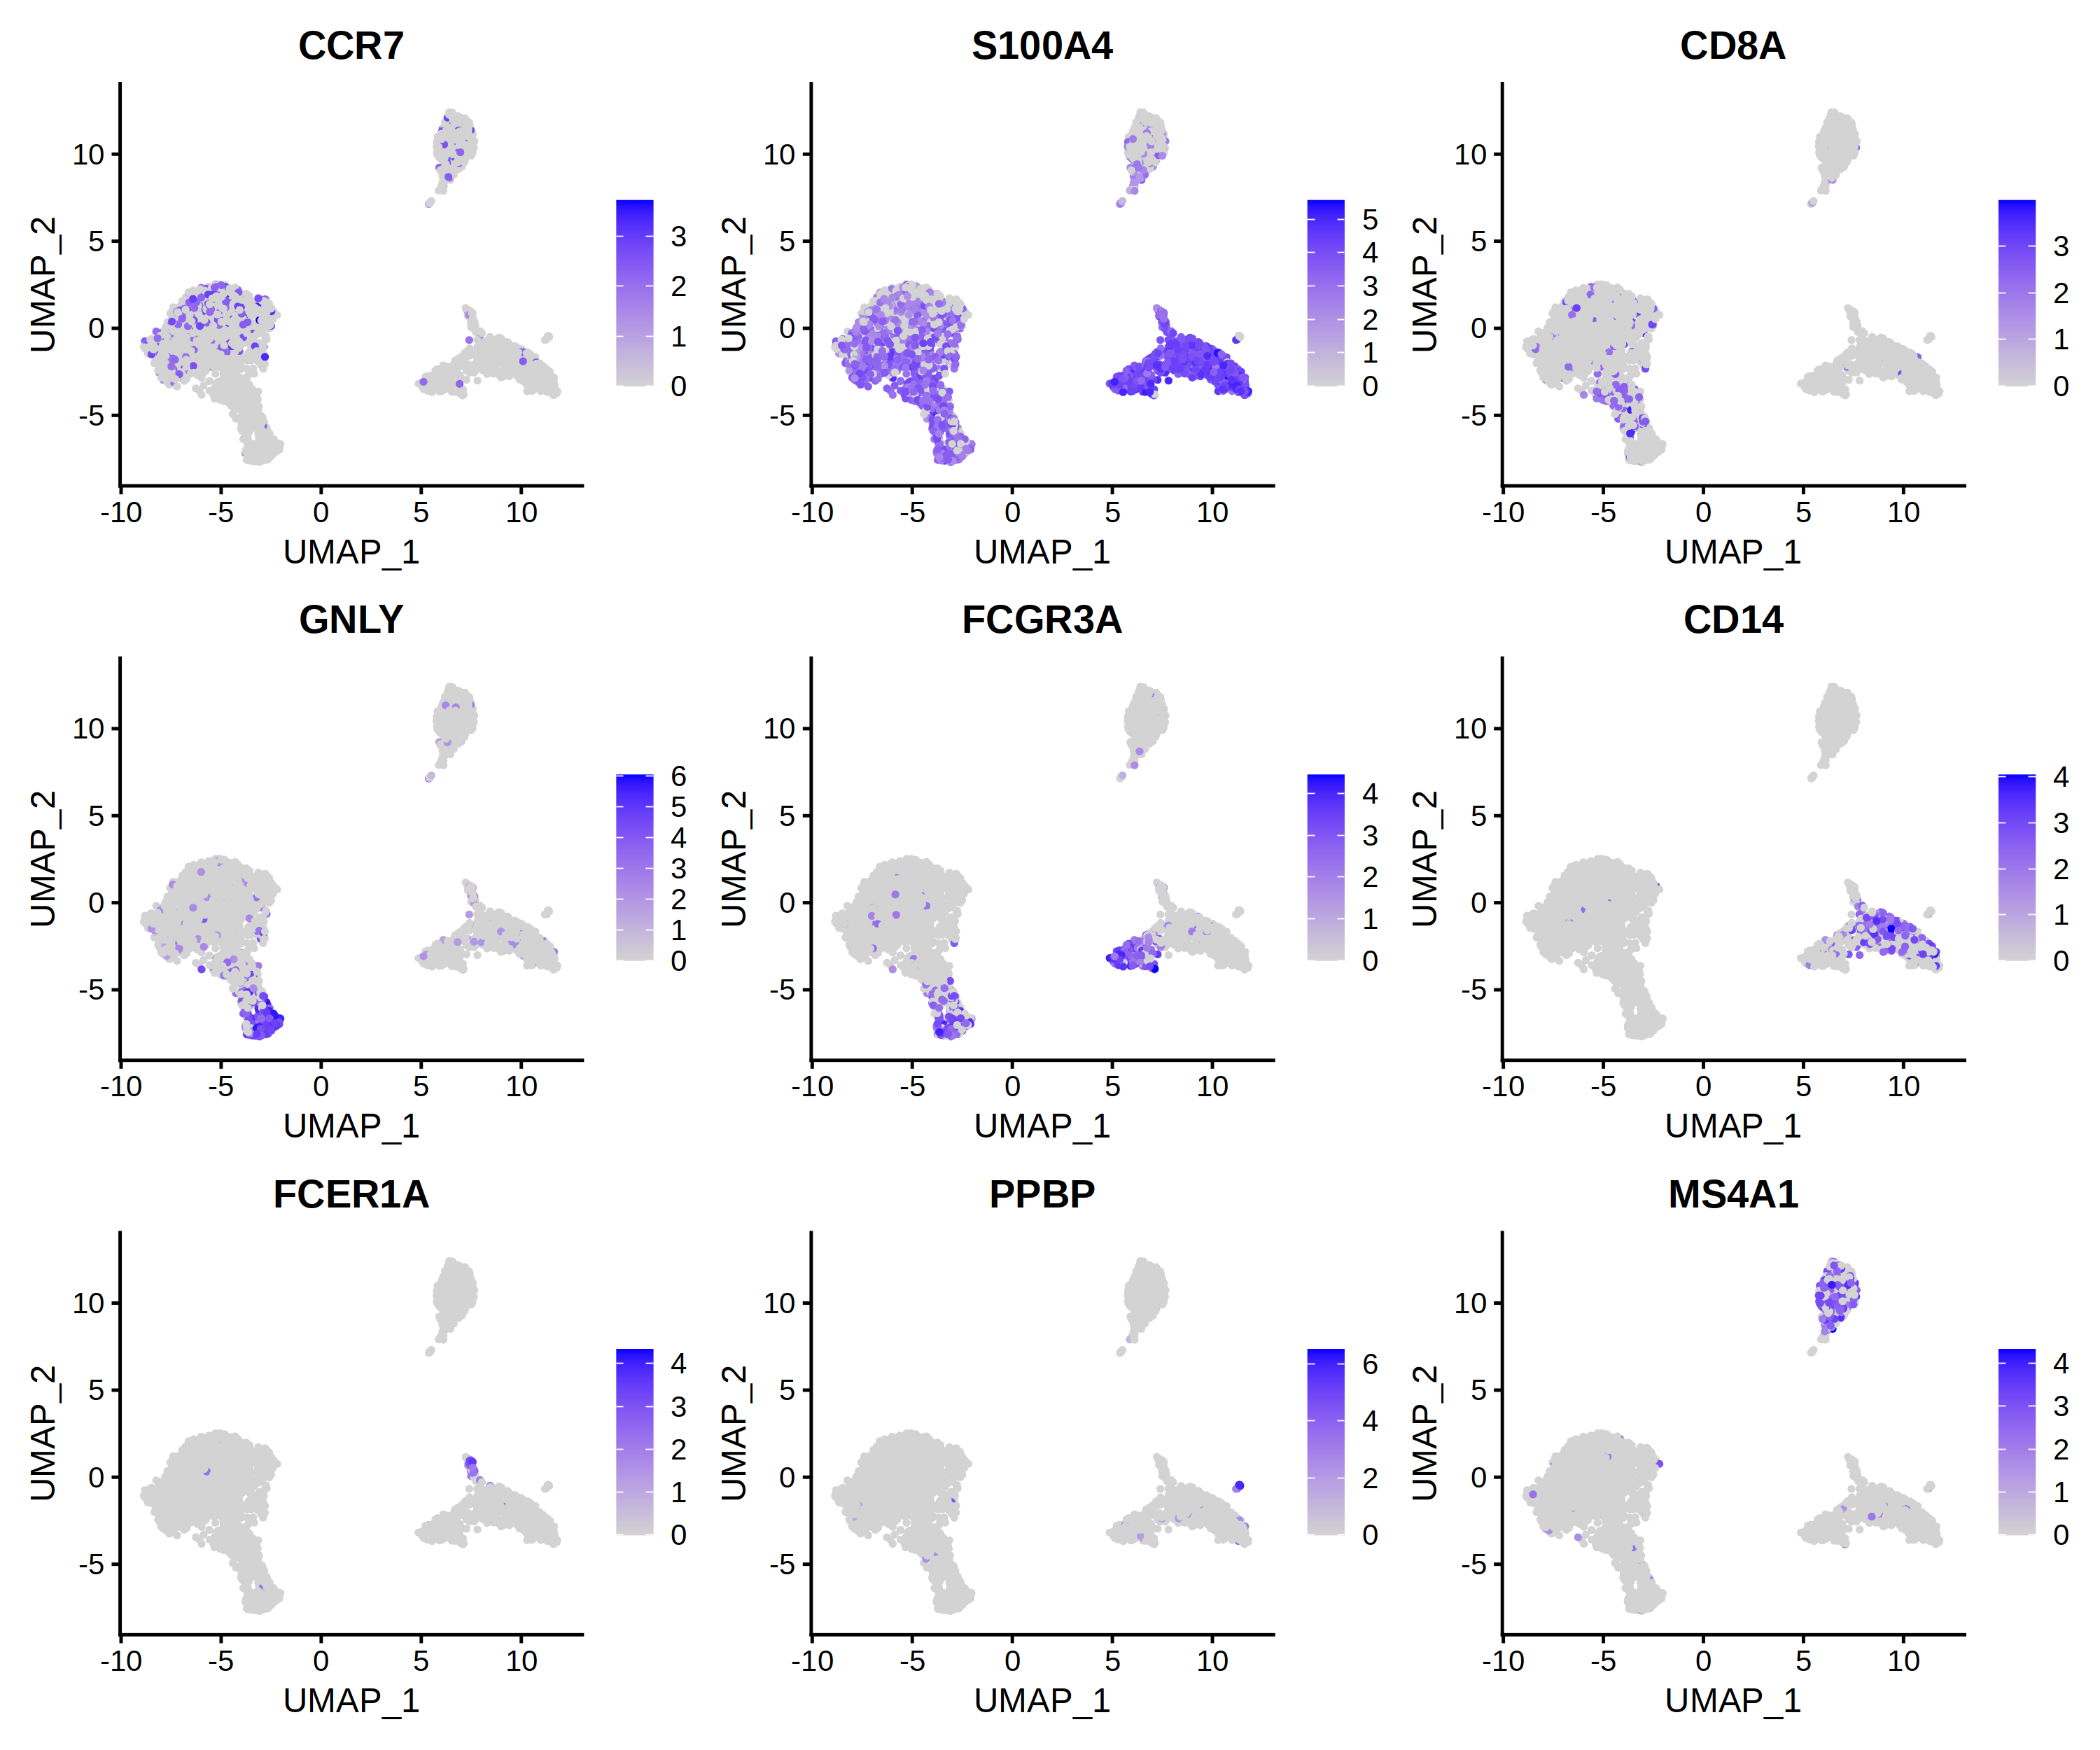

In [11]:
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 250)
FeaturePlot(pbmc.test, 
            features = c("CCR7",    # Naive CD4+ T
                         "S100A4",  # memory CD4+
                         "CD8A",    # CD8T
                         "GNLY",    # NK 

                         "FCGR3A",  # FCGR3A+ mono
                         "CD14",    # CD14+ mono
                         "FCER1A",  # DC

                         "PPBP",    # Platelet 
                         "MS4A1"  # B
                         ))

In [12]:
#train vs full
clusters.train <- Idents(pbmc.train)
clusters.full <- Idents(pbmc)[colnames(pbmc.train)] 

adjustedRandIndex(clusters.train, clusters.full)
table(clusters.train, clusters.full)

[1] 0.7711931

              clusters.full
clusters.train   0   1   2   3   4   5   6   7   8
             0 619   0  87   0  14   0   0   0   0
             1   0 460   0   0   0   3   0   1   0
             2  57   0 382   0  20   0   0   0   0
             3   0   0   4   1 250   0 154   0   0
             4   0   0   2 342   1   0   0   2   0
             5   0   9   0   0   0 159   0   0   7
             6   0   1   0   0   0   0   0  29   0

In [13]:
#train vs test.denovo
#note that 0 and 2 are not agreeing with each other
clusters.train       <- pbmc.test@meta.data[colnames(pbmc.train), "train.anno"] 
clusters.test.denovo <- pbmc.test@meta.data[colnames(pbmc.train), "seurat_clusters"] 

adjustedRandIndex(clusters.train, clusters.test.denovo)
table(clusters.train, clusters.test.denovo)

[1] 0.6368087

              clusters.test.denovo
clusters.train   0   1   2   3   4   5   6   7
             0 253   0 434   0  35   0   0   0
             1   0 459   0   0   0   3   0   4
             2 400   0  28   0  31   0   0   0
             3  11   0   4   1 260   0 134   0
             4   1   0   3 339   0   0   8   1
             5   0  13   0   0   0 163   0   0
             6   0   5   0   1   0   0   0  24

# explore DE on B-cells vs rest

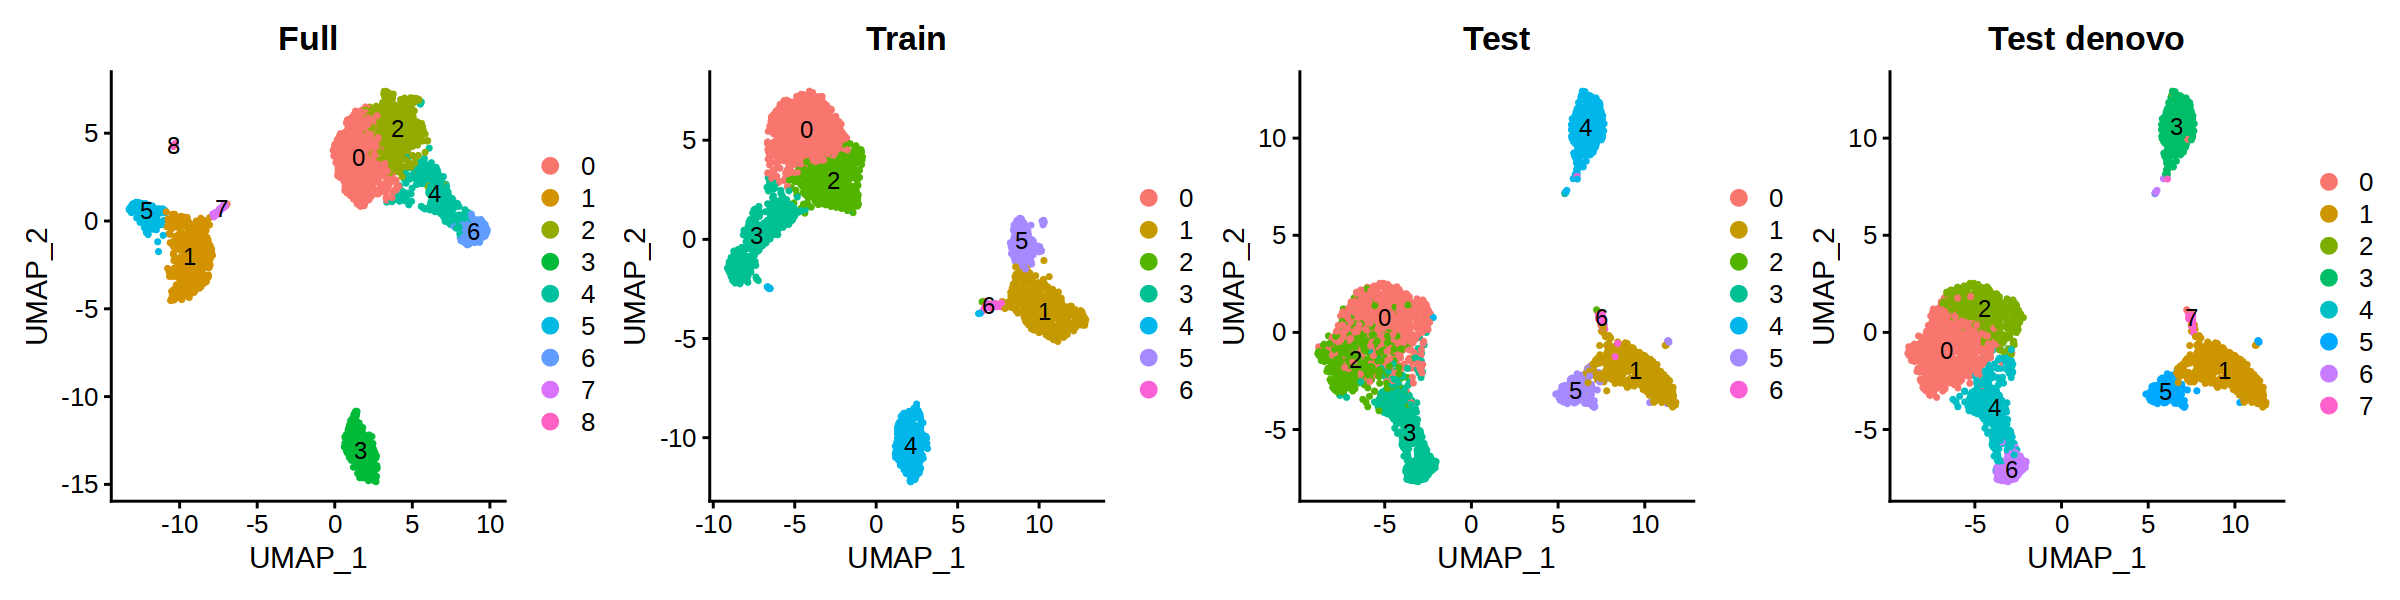

In [41]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
p1 + p2 + p3 + p4 + plot_layout(nrow=1, ncol=4)

In [14]:
markers.naive.full       <- FindMarkers(pbmc,       ident.1=3, min.pct=0, logfc.threshold = 0)
markers.countsplit.train <- FindMarkers(pbmc.train, ident.1=4, min.pct=0, logfc.threshold = 0)
# test is using train's label
pbmc.test <- SetIdent(pbmc.test, value = pbmc.test@meta.data$train.anno)
markers.countsplit.test  <- FindMarkers(pbmc.test,  ident.1=4, min.pct=0, logfc.threshold = 0)

# test is using test's own label
pbmc.test <- SetIdent(pbmc.test, value = pbmc.test@meta.data$seurat_clusters)
markers.countsplit.test.denovo  <- FindMarkers(pbmc.test,  ident.1=3, min.pct=0, logfc.threshold = 0)

In [15]:
markers.naive.full

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MS4A1,0.000000e+00,3.378150,0.855,0.053,0.000000e+00
CD79A,0.000000e+00,4.310172,0.936,0.041,0.000000e+00
CD79B,2.655974e-274,3.481908,0.916,0.142,3.642403e-270
LINC00926,2.397625e-272,2.842677,0.564,0.009,3.288103e-268
TCL1A,9.481783e-271,3.591579,0.622,0.022,1.300332e-266
HLA-DQA1,2.942395e-266,3.057896,0.890,0.118,4.035201e-262
VPREB3,2.745016e-237,2.424806,0.488,0.007,3.764515e-233
HLA-DQB1,1.171932e-229,3.076822,0.863,0.147,1.607187e-225
CD74,5.255736e-185,2.920957,1.000,0.821,7.207717e-181


In [16]:
markers.countsplit.train

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD79A,0.000000e+00,4.3539404,0.761,0.018,0.000000e+00
CD79B,2.074152e-237,3.3945841,0.744,0.077,2.576304e-233
MS4A1,1.058362e-226,3.3363514,0.594,0.034,1.314592e-222
HLA-DQA1,2.938453e-214,3.0552484,0.719,0.080,3.649852e-210
TCL1A,1.672126e-213,3.5560869,0.480,0.012,2.076948e-209
HLA-DQB1,3.206385e-199,3.0832184,0.696,0.086,3.982651e-195
CD74,6.101710e-186,2.8925299,1.000,0.654,7.578934e-182
HLA-DRA,1.413910e-183,2.7274389,0.989,0.384,1.756217e-179
LINC00926,9.602543e-168,2.8452842,0.349,0.004,1.192732e-163


In [17]:
markers.countsplit.test

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD79A,0.000000e+00,4.2002159,0.776,0.025,0.000000e+00
MS4A1,3.846416e-266,3.3587411,0.614,0.021,4.777634e-262
CD79B,2.380250e-236,3.4768070,0.756,0.085,2.956509e-232
TCL1A,1.025480e-227,3.5895605,0.497,0.011,1.273748e-223
HLA-DQA1,9.052311e-203,2.9741888,0.690,0.077,1.124387e-198
HLA-DRA,4.932989e-190,2.7257093,0.994,0.386,6.127265e-186
CD74,1.453555e-186,2.9179385,1.000,0.635,1.805460e-182
HLA-DQB1,5.734782e-174,2.9975390,0.662,0.093,7.123173e-170
LINC00926,1.023718e-155,2.7549026,0.341,0.006,1.271560e-151


In [18]:
markers.countsplit.test.denovo

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD79A,0.000000e+00,4.2201114,0.792,0.026,0.000000e+00
MS4A1,5.627752e-268,3.3697282,0.625,0.022,6.990230e-264
CD79B,3.561929e-238,3.4899012,0.768,0.086,4.424272e-234
TCL1A,1.217976e-233,3.6316773,0.510,0.011,1.512848e-229
HLA-DQA1,6.293094e-203,3.0097742,0.698,0.079,7.816652e-199
HLA-DRA,7.032893e-189,2.7353706,0.997,0.389,8.735556e-185
CD74,3.797600e-186,2.9329339,1.000,0.637,4.716999e-182
HLA-DQB1,6.124977e-172,3.0195654,0.666,0.095,7.607834e-168
LINC00926,8.011586e-162,2.8090486,0.352,0.006,9.951192e-158


Warning message:
“Removed 2 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”


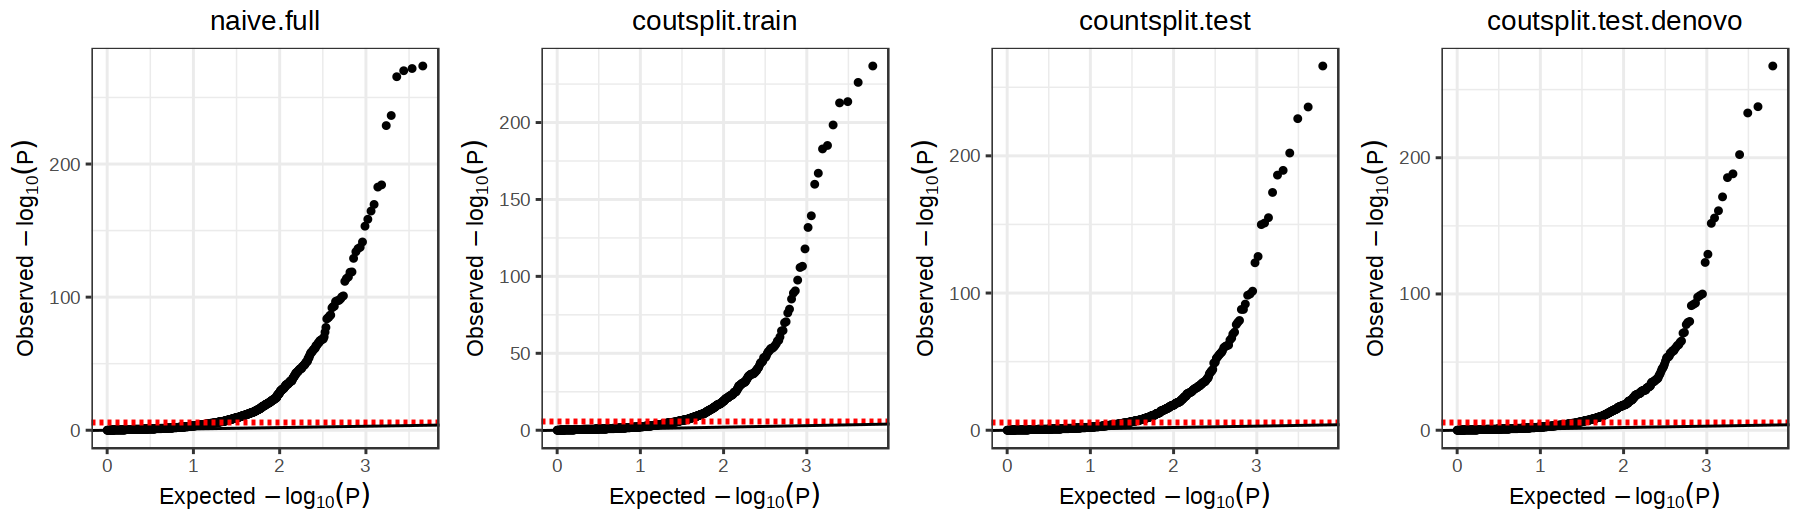

In [19]:
g = plot_qq(list(markers.naive.full[,"p_val"],
                 markers.countsplit.train[,"p_val"],
                 markers.countsplit.test[,"p_val"],
                 markers.countsplit.test.denovo[,"p_val"]), 
            ggarrange.nrow = 1, ggarrange.ncol = 4,  
            labels = c("naive.full", "coutsplit.train", "countsplit.test", "coutsplit.test.denovo"))
options(repr.plot.width = 12, repr.plot.height = 3.5, repr.plot.res = 150)
g

Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 2 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 2 rows containing non-finite values (stat_binhex).”


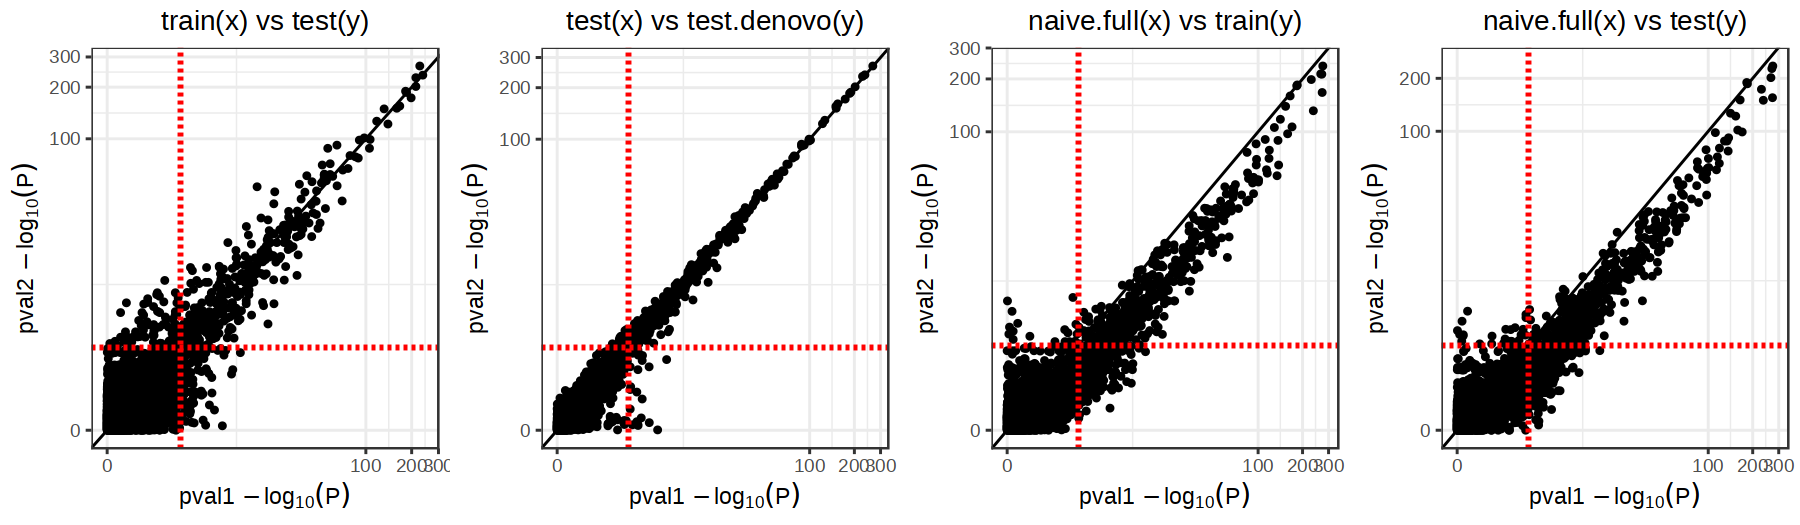

In [20]:
g = plot_qq_compare(pvals = list(pvals_intersect(markers.countsplit.train[,"p_val", drop=F], 
                                             markers.countsplit.test [,"p_val", drop=F]),
                                 pvals_intersect(markers.countsplit.test[,"p_val", drop=F], 
                                                 markers.countsplit.test.denovo[,"p_val", drop=F]),
                                 pvals_intersect(markers.naive.full[,"p_val", drop=F], 
                                                 markers.countsplit.train [,"p_val", drop=F]),
                                 pvals_intersect(markers.naive.full[,"p_val", drop=F], 
                                                 markers.countsplit.test [,"p_val", drop=F])),
                    labels = c("train(x) vs test(y)", 
                               "test(x) vs test.denovo(y)", 
                               "naive.full(x) vs train(y)", 
                               "naive.full(x) vs test(y)"),
                    ggarrange.nrow = 1, ggarrange.ncol = 4)
options(repr.plot.width = 12, repr.plot.height = 3.5, repr.plot.res = 150)
g

##### figure caption
absolutely no difference in first 2 pannels if the cluster is obviously real biological cluster <br>
especially when color cells by train lable in test UMAP show perfect concordance/seperation <br>
should probably expect exact same behavior/similar pval distribution between train, test, test.denovo (if split under half half)

# explore DE sub-cluster in CD vs rest (shown as tutorial in their package)

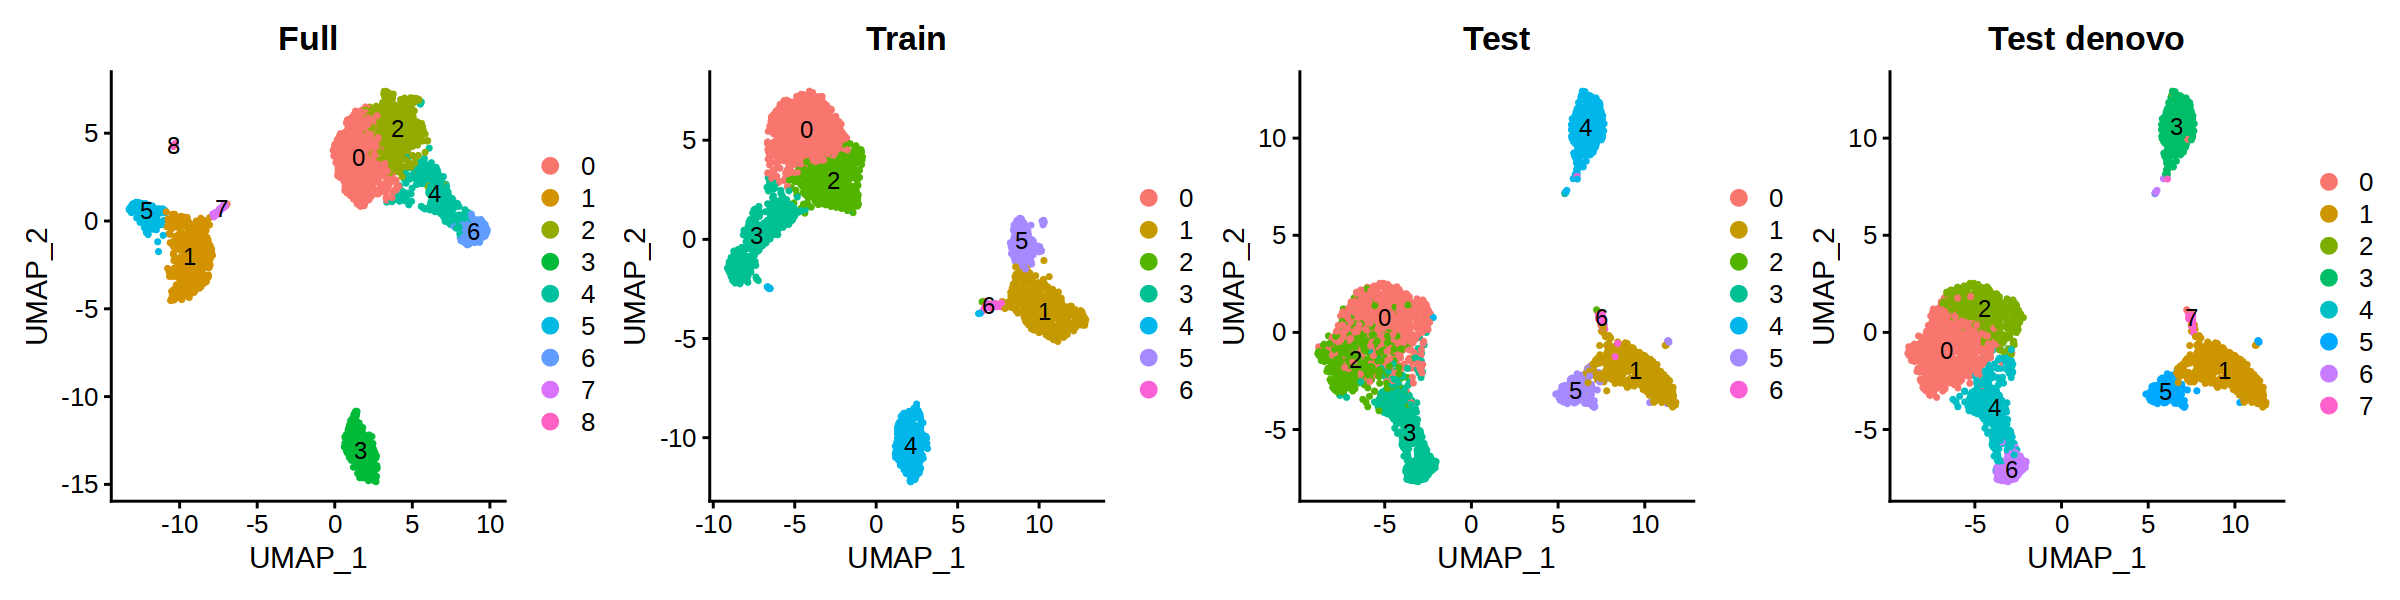

In [42]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
p1 + p2 + p3 + p4 + plot_layout(nrow=1, ncol=4)

In [22]:
markers.naive.full       <- FindMarkers(pbmc,       ident.1=2, min.pct=0, logfc.threshold = 0)
markers.countsplit.train <- FindMarkers(pbmc.train, ident.1=2, min.pct=0, logfc.threshold = 0)
# test is using train's label
pbmc.test <- SetIdent(pbmc.test, value = pbmc.test@meta.data$train.anno)
markers.countsplit.test  <- FindMarkers(pbmc.test,  ident.1=2, min.pct=0, logfc.threshold = 0)

# test is using test's own label
pbmc.test <- SetIdent(pbmc.test, value = pbmc.test@meta.data$seurat_clusters)
markers.countsplit.test.denovo  <- FindMarkers(pbmc.test,  ident.1=0, min.pct=0, logfc.threshold = 0)

In [23]:
markers.naive.full

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,2.892340e-90,1.2013522,0.947,0.465,3.966555e-86
LTB,1.060121e-86,1.2695776,0.981,0.643,1.453850e-82
CD3D,8.794641e-71,0.9389621,0.922,0.432,1.206097e-66
IL7R,3.516098e-68,1.1873213,0.750,0.326,4.821977e-64
LDHB,1.642480e-67,0.8969774,0.954,0.614,2.252497e-63
CD2,3.436996e-59,1.2208582,0.651,0.245,4.713496e-55
AQP3,2.966019e-58,1.2277973,0.420,0.111,4.067598e-54
TNFRSF4,1.507652e-54,0.9517041,0.210,0.025,2.067595e-50
CD3E,3.323945e-54,0.8678911,0.830,0.410,4.558458e-50


In [24]:
markers.countsplit.train

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,1.496040e-79,1.2950693,0.839,0.363,1.858232e-75
LTB,1.736679e-70,1.2400968,0.917,0.527,2.157129e-66
IL7R,1.746174e-55,1.0999529,0.593,0.213,2.168923e-51
HLA-DRA,1.636986e-49,-3.4809399,0.205,0.520,2.033300e-45
LDHB,3.021188e-49,0.9459521,0.824,0.439,3.752618e-45
CD74,5.244128e-49,-2.4468074,0.582,0.725,6.513731e-45
CD3D,2.878114e-48,0.8986919,0.734,0.322,3.574905e-44
TNFRSF4,2.040386e-47,1.1262521,0.142,0.009,2.534364e-43
HLA-DRB1,7.857658e-47,-2.6901986,0.098,0.440,9.759998e-43


In [25]:
markers.countsplit.test

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LTB,1.024995e-69,1.2573889,0.904,0.521,1.273146e-65
IL32,2.795907e-65,1.2014270,0.800,0.363,3.472796e-61
IL7R,1.555729e-52,1.1410766,0.575,0.213,1.932370e-48
CD3D,1.822045e-52,0.9193555,0.758,0.327,2.263162e-48
HLA-DRA,2.461172e-50,-3.3849585,0.205,0.524,3.057022e-46
TYROBP,3.652260e-47,-3.5375959,0.065,0.404,4.536472e-43
LDHB,6.409036e-45,0.8943173,0.813,0.439,7.960663e-41
HLA-DPB1,1.208847e-43,-2.6613164,0.155,0.469,1.501509e-39
HLA-DRB1,5.578914e-43,-2.5094670,0.107,0.433,6.929570e-39


In [26]:
markers.countsplit.test.denovo

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LTB,1.127675e-93,1.2490816,0.902,0.482,1.400686e-89
HLA-DRA,8.197377e-81,-3.5186746,0.198,0.560,1.018196e-76
LDHB,1.675311e-78,1.1135372,0.817,0.398,2.080903e-74
TYROBP,3.152719e-76,-3.7090349,0.060,0.442,3.915992e-72
IL32,2.494217e-74,1.0366901,0.768,0.328,3.098067e-70
CD3D,7.650310e-72,0.9852067,0.740,0.287,9.502450e-68
IL7R,1.717005e-71,1.2761156,0.556,0.181,2.132692e-67
CD74,5.279102e-69,-2.5359302,0.562,0.726,6.557172e-65
HLA-DPB1,5.269316e-68,-2.7693795,0.158,0.501,6.545017e-64


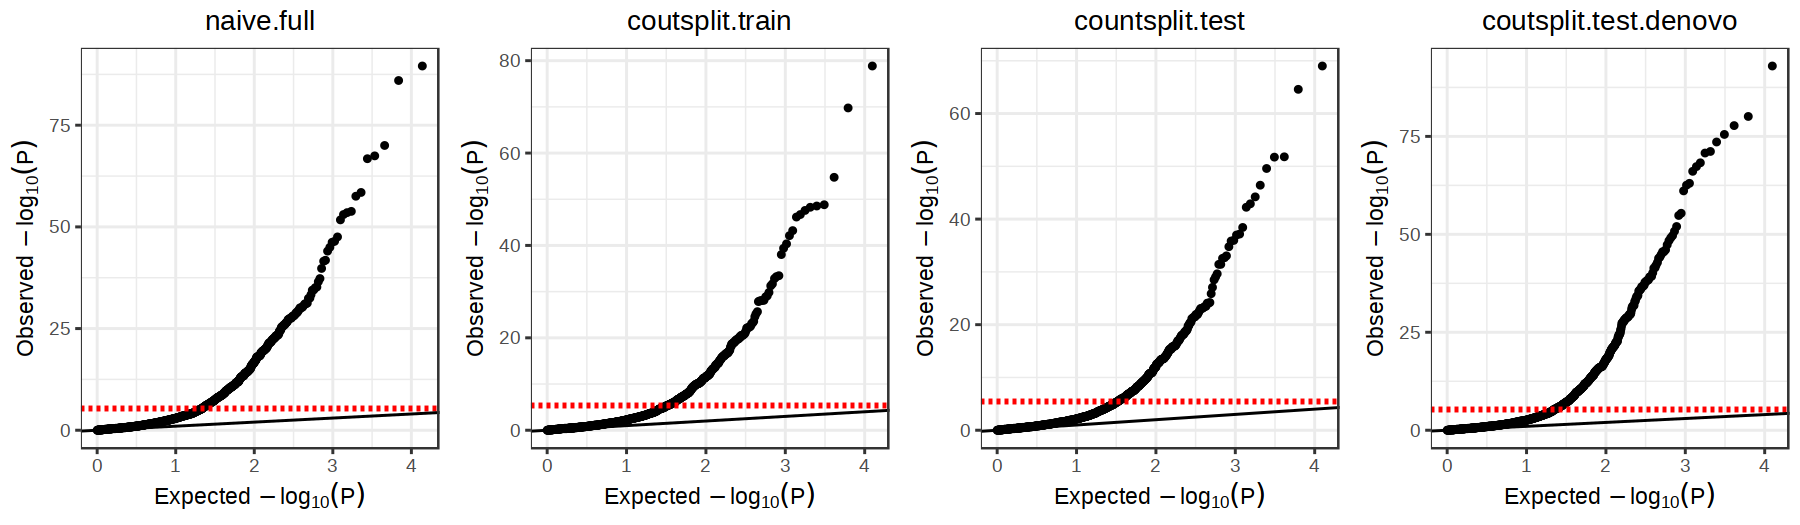

In [27]:
g = plot_qq(list(markers.naive.full[,"p_val"],
                 markers.countsplit.train[,"p_val"],
                 markers.countsplit.test[,"p_val"],
                 markers.countsplit.test.denovo[,"p_val"]), 
            ggarrange.nrow = 1, ggarrange.ncol = 4,  
            labels = c("naive.full", "coutsplit.train", "countsplit.test", "coutsplit.test.denovo"))
options(repr.plot.width = 12, repr.plot.height = 3.5, repr.plot.res = 150)
g

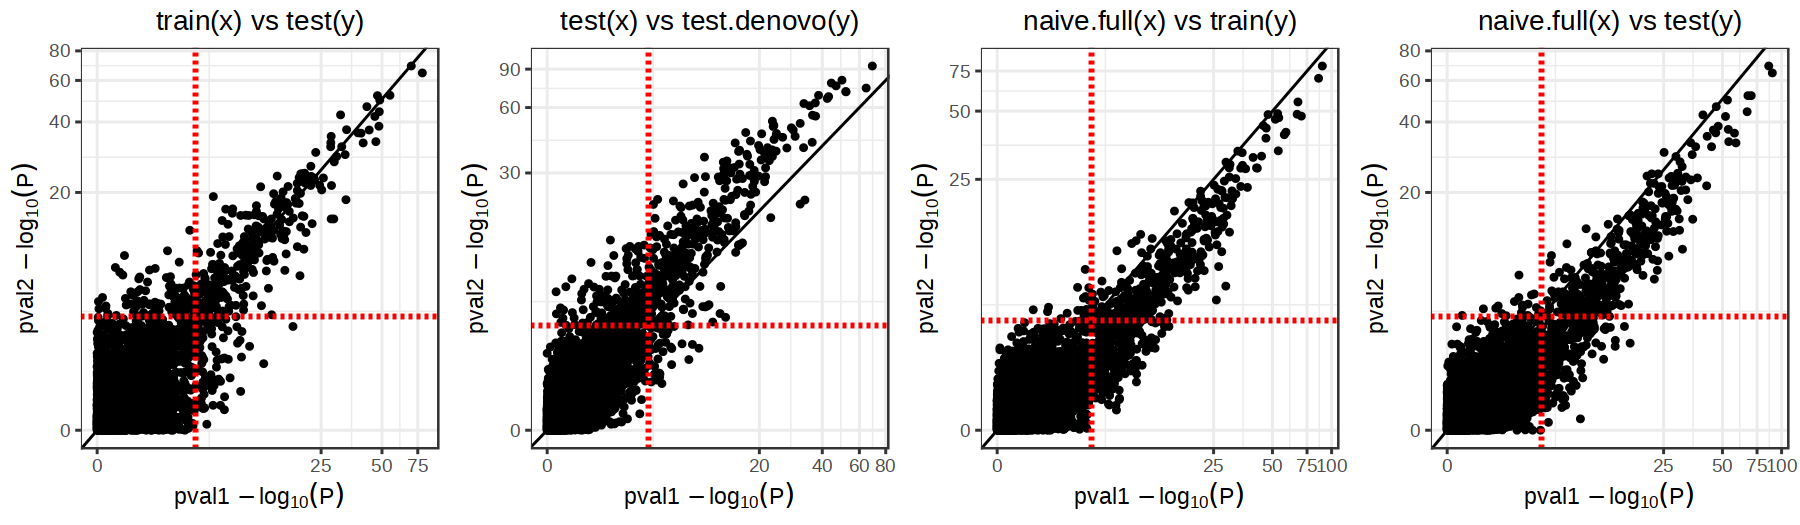

In [28]:
g = plot_qq_compare(pvals = list(pvals_intersect(markers.countsplit.train[,"p_val", drop=F], 
                                             markers.countsplit.test [,"p_val", drop=F]),
                                 pvals_intersect(markers.countsplit.test[,"p_val", drop=F], 
                                                 markers.countsplit.test.denovo[,"p_val", drop=F]),
                                 pvals_intersect(markers.naive.full[,"p_val", drop=F], 
                                                 markers.countsplit.train [,"p_val", drop=F]),
                                 pvals_intersect(markers.naive.full[,"p_val", drop=F], 
                                                 markers.countsplit.test [,"p_val", drop=F])),
                    labels = c("train(x) vs test(y)", 
                               "test(x) vs test.denovo(y)", 
                               "naive.full(x) vs train(y)", 
                               "naive.full(x) vs test(y)"),
                    ggarrange.nrow = 1, ggarrange.ncol = 4)
options(repr.plot.width = 12, repr.plot.height = 3.5, repr.plot.res = 150)
g

##### figure caption
almost no difference in pannel 1, some decent control in pannel 2 (doubledip test inflates a little vs using label from train) <br>
color cells by train lable in test UMAP show not 100% perfect concordance/seperation  <br>
but since the test is done in a one-vs-all fashion, cannot see the difference clear

# explore DE sub-cluster in CD

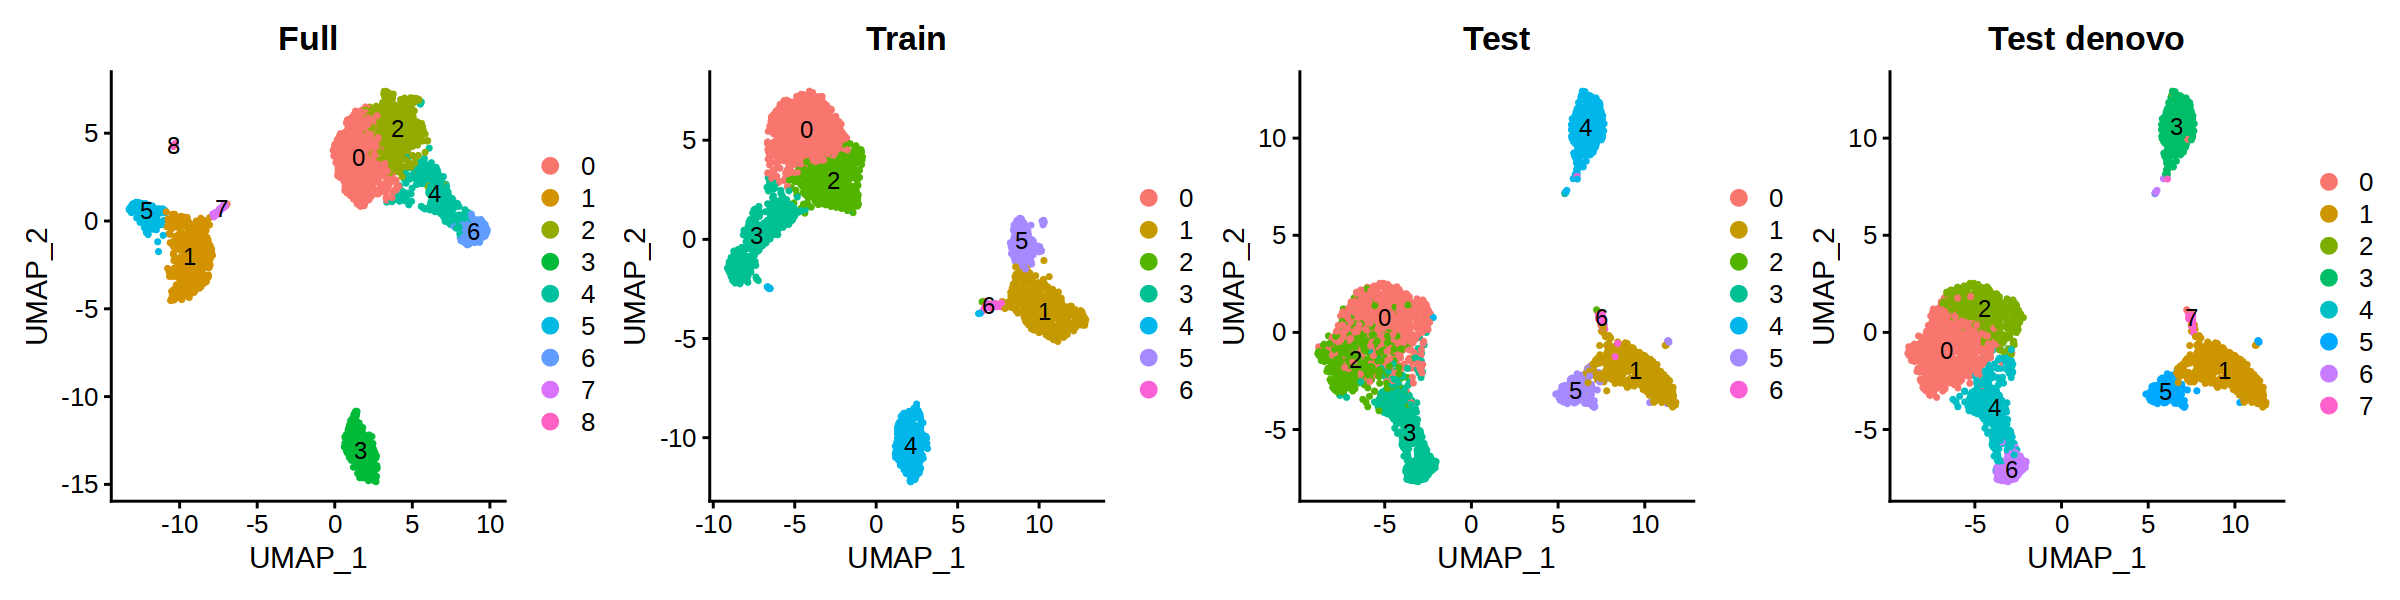

In [43]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
p1 + p2 + p3 + p4 + plot_layout(nrow=1, ncol=4)

In [29]:
markers.naive.full       <- FindMarkers(pbmc,       ident.1=0, ident.2 =2, min.pct=0, logfc.threshold = 0)
markers.countsplit.train <- FindMarkers(pbmc.train, ident.1=0, ident.2 =2, min.pct=0, logfc.threshold = 0)
# test is using train's label
pbmc.test <- SetIdent(pbmc.test, value = pbmc.test@meta.data$train.anno)
markers.countsplit.test  <- FindMarkers(pbmc.test,  ident.1=0, ident.2 =2, min.pct=0, logfc.threshold = 0)

# test is using test's own label
pbmc.test <- SetIdent(pbmc.test, value = pbmc.test@meta.data$seurat_clusters)
markers.countsplit.test.denovo  <- FindMarkers(pbmc.test,  ident.1=2, ident.2 =0, min.pct=0, logfc.threshold = 0)

In [30]:
markers.naive.full

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A4,9.932175e-69,-1.3491224,0.680,0.952,1.362099e-64
B2M,5.228406e-51,-0.3937814,1.000,1.000,7.170236e-47
ANXA1,4.482255e-34,-1.0100898,0.485,0.805,6.146965e-30
RPL32,2.262122e-33,0.3241148,0.999,1.000,3.102274e-29
MALAT1,1.116807e-32,0.4297901,1.000,1.000,1.531589e-28
S100A11,2.437686e-31,-1.0414585,0.279,0.628,3.343043e-27
IL32,1.233588e-30,-0.7904046,0.770,0.947,1.691743e-26
SH3BGRL3,1.307539e-30,-0.8271760,0.732,0.929,1.793160e-26
ANXA2,3.321323e-30,-1.0376108,0.167,0.487,4.554862e-26


In [31]:
markers.countsplit.train

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A4,8.213787e-60,-1.3200807,0.485,0.882,1.020235e-55
MALAT1,3.089719e-34,0.4484871,1.000,1.000,3.837740e-30
B2M,1.024789e-33,-0.3463952,1.000,1.000,1.272890e-29
S100A11,2.187453e-26,-1.1253737,0.162,0.460,2.717036e-22
IL32,9.185366e-26,-0.8469030,0.587,0.839,1.140914e-21
ACTB,1.792616e-22,-0.5489423,0.945,0.989,2.226609e-18
VIM,4.266482e-22,-0.6613531,0.607,0.837,5.299397e-18
RPS3A,3.192429e-18,0.4146708,0.983,0.991,3.965317e-14
RPL32,4.749282e-18,0.2958704,0.993,1.000,5.899083e-14


In [32]:
markers.countsplit.test

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A4,3.976495e-48,-1.1554955,0.530,0.880,4.939205e-44
B2M,5.972231e-36,-0.3666298,0.999,1.000,7.418108e-32
MALAT1,3.493614e-29,0.4346364,1.000,1.000,4.339418e-25
ANXA2,3.339411e-22,-1.0266299,0.082,0.307,4.147882e-18
ANXA1,3.477458e-21,-0.8379773,0.321,0.619,4.319351e-17
S100A11,6.050068e-19,-0.9688311,0.157,0.399,7.514790e-15
VIM,6.432463e-19,-0.6410842,0.641,0.837,7.989763e-15
RPL21,3.272458e-18,0.3347723,0.992,0.996,4.064719e-14
ACTB,2.051291e-17,-0.5103667,0.949,0.993,2.547909e-13


In [33]:
markers.countsplit.test.denovo

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A4,2.109401e-34,-1.1241255,0.461,0.800,2.620087e-30
B2M,2.494870e-31,-0.3674883,0.998,1.000,3.098878e-27
ANXA1,5.435728e-31,-1.1636874,0.220,0.594,6.751718e-27
MALAT1,9.195499e-31,0.4428179,1.000,1.000,1.142173e-26
VIM,5.642407e-24,-0.7952088,0.561,0.836,7.008433e-20
LTB,1.309624e-17,-0.6290997,0.725,0.902,1.626683e-13
KLF6,1.619695e-17,-0.8380122,0.264,0.555,2.011823e-13
CLIC1,1.665928e-16,-0.9700027,0.154,0.402,2.069249e-12
ANXA2,3.342651e-16,-1.0319536,0.053,0.241,4.151907e-12


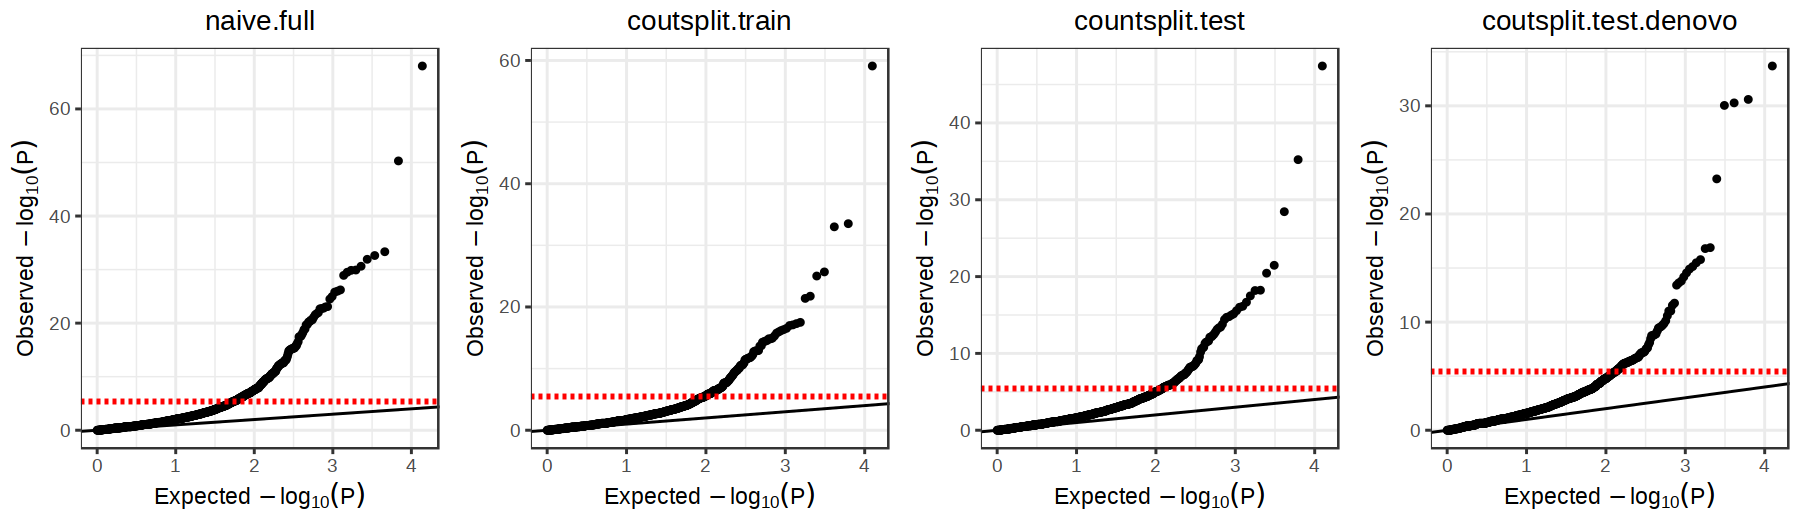

In [34]:
g = plot_qq(list(markers.naive.full[,"p_val"],
                 markers.countsplit.train[,"p_val"],
                 markers.countsplit.test[,"p_val"],
                 markers.countsplit.test.denovo[,"p_val"]), 
            ggarrange.nrow = 1, ggarrange.ncol = 4,  
            labels = c("naive.full", "coutsplit.train", "countsplit.test", "coutsplit.test.denovo"))
options(repr.plot.width = 12, repr.plot.height = 3.5, repr.plot.res = 150)
g

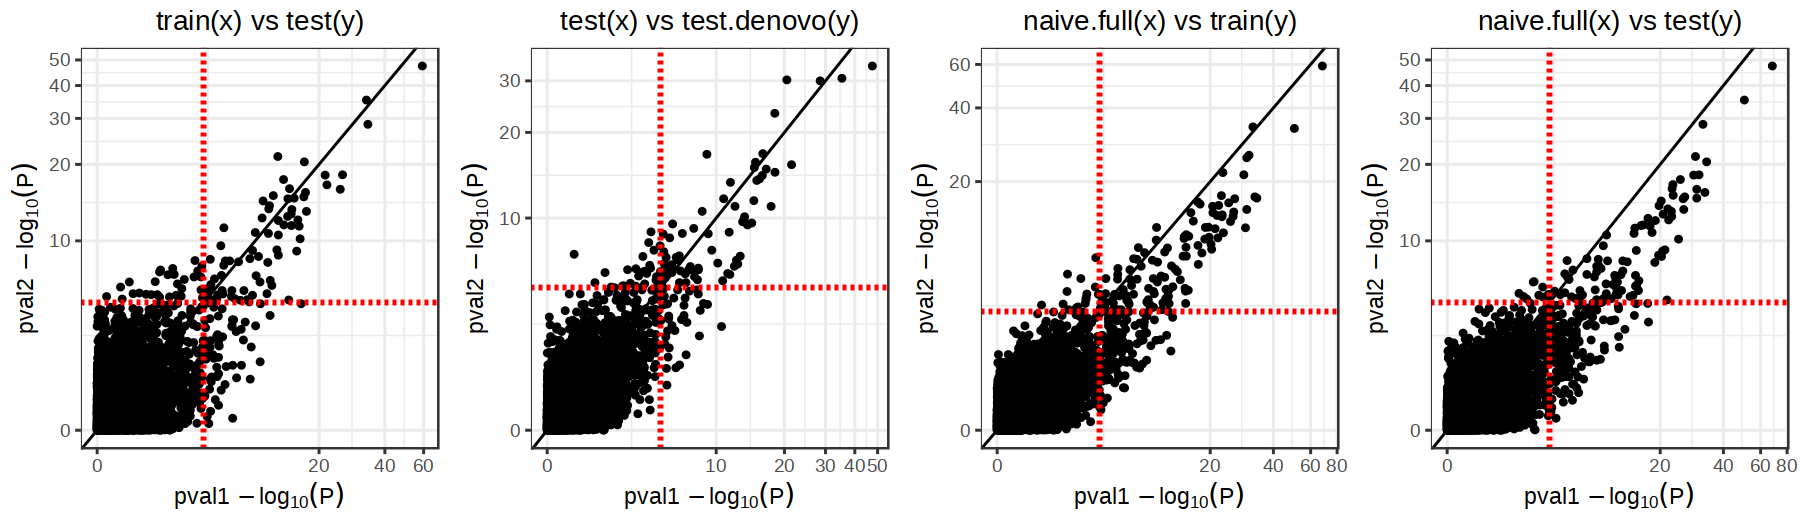

In [35]:
g = plot_qq_compare(pvals = list(pvals_intersect(markers.countsplit.train[,"p_val", drop=F], 
                                             markers.countsplit.test [,"p_val", drop=F]),
                                 pvals_intersect(markers.countsplit.test[,"p_val", drop=F], 
                                                 markers.countsplit.test.denovo[,"p_val", drop=F]),
                                 pvals_intersect(markers.naive.full[,"p_val", drop=F], 
                                                 markers.countsplit.train [,"p_val", drop=F]),
                                 pvals_intersect(markers.naive.full[,"p_val", drop=F], 
                                                 markers.countsplit.test [,"p_val", drop=F])),
                    labels = c("train(x) vs test(y)", 
                               "test(x) vs test.denovo(y)", 
                               "naive.full(x) vs train(y)", 
                               "naive.full(x) vs test(y)"),
                    ggarrange.nrow = 1, ggarrange.ncol = 4)
options(repr.plot.width = 12, repr.plot.height = 3.5, repr.plot.res = 150)
g

##### figure caption
minor control in pannel 1, almost no difference in pannel 2 <br>
color cells by train lable in test UMAP show not 100% perfect concordance/seperation <br>
specifically asking to test the two very correlated (close in linage) celltypes  <br>
still the result is no where near as dramatic in controlling FP as in the negative control case